In [2]:
import tidy3d as td
import numpy as np
import tidy3d.web as web
import scipy.interpolate

# Effective refractive index calculation from tidy3d
def var_eps_eff(point, ref_point, sim, wavelength=1.55, inf=1000):
    """
    To calculate the vertical slab mode at 'point', we will create a 2D slice of the given simulation at
    'point' that extends in the yz plane infinitely, ensuring that it captures the entire permittivity
    profile. Then, to find the 1D mode profile, we use the Tidy3D ModeSolver on a plane at 'point' that
    extends infinitely in the xz plane. This intersection results in the ModeSolver operating on a line
    at 'point' that covers its entire z profile. We then use this to solve for n_eff and M in the above
    formula.
    """
    sim_2d_center = (point[0], point[1], 0) # given a 3D sim, we update the center to create our 2D slice
    sim_2d_size = (0, inf, inf) # we ensure the 2D span of the simulation in the yz plane captures everything
    
    # now we create the 2D simulation, keeping the structures and updating the boundary conditions
    sim_2d = sim.updated_copy(center=sim_2d_center,
                              size=sim_2d_size,
                              sources=[],
                              monitors=[],
                              boundary_spec=sim.boundary_spec.updated_copy(x=td.Boundary.periodic())
                             )
    
    # Now we solve for the mode at 'point':
    # We create the plane in xz that we'll use to examine the mode in z
    mode_solver_plane = td.Box(center=sim_2d.center, size=(td.inf, 0, td.inf))
    # Now we define the mode solver using this plane. We need only solve for one mode here, hence the ModeSpec
    mode_solver = td.plugins.mode.ModeSolver(simulation=sim_2d,
                                             plane=mode_solver_plane,
                                             mode_spec=td.ModeSpec(num_modes=1),
                                             freqs=[td.C_0/wavelength])
    
    # Note that here the mode solving is done locally. For users desiring more accuracy, the remote mode
    # solver should be used.
    mode_data = mode_solver.solve()
    
    # get n_eff from the solver
    n_eff = mode_data.n_eff.item()
    if point == ref_point: return n_eff**2 # if point is the reference point, the integral is 0

    # get z permittivity profile at reference point
    x_ref, y_ref = ref_point
    eps_ref = sim.epsilon(box=td.Box(center=(x_ref, y_ref, list(sim.center)[2]), size=(0,0,td.inf)))
    
    # get z permittivity profile at 'point'
    x, y = point
    eps = sim.epsilon(box=td.Box(center=(x, y, list(sim.center)[2]), size=(0,0,td.inf)))
    
    eps_dif = np.squeeze(eps.values) - np.squeeze(eps_ref.values)

    # get M at the same z coordinates as those of (eps - eps_ref) so we can integrate their product
    z_coords = eps_ref.z.values
    mode_profile = mode_data.Ex
    Mz2 = scipy.interpolate.interp1d(x=mode_profile.z.values, y=np.abs(np.squeeze(mode_profile.values))**2)
    m_values = Mz2(z_coords)

    # calculate integrals
    num, denom = np.trapz(y=eps_dif*m_values, x=z_coords), np.trapz(y=m_values, x=z_coords)
    return n_eff**2 + num/denom

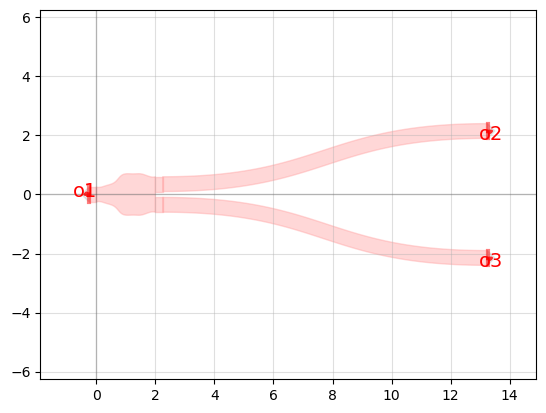

2024-04-20 16:06:39.143 | INFO     | gdsfactory.component:_write_library:2003 - Wrote to 'y_junction.gds'
Cell names: mmi1x2_with_sbend
Cell 'mmi1x2_with_sbend' with 6 polygons, 0 flexpaths, 0 robustpaths, 0 references, and 0 labels


In [3]:
import gdsfactory as gf
import gplugins.gmeep as gm
import gplugins
import gdstk

c = gf.components.mmi1x2_with_sbend(with_sbend=True)
c.plot()

c.write_gds("y_junction.gds")

# # Load a GDSII library from the file we just created
lib_loaded = gdstk.read_gds("y_junction.gds")

# Create a cell dictionary with all the cells in the file
all_cells = {c.name: c for c in lib_loaded.cells}

print("Cell names: " + ", ".join(all_cells.keys()))

print(lib_loaded.cells)

coup_cell_loaded = all_cells[c.name]

print(coup_cell_loaded)


16:40:50 CEST WARNING: A bound of Simulation.structures[0] was detected as being
              within the simulation PML. We recommend extending structures to   
              infinity or completely outside of the simulation PML to avoid     
              unexpected effects when the structures are not translationally    
              invariant within the PML.                                         

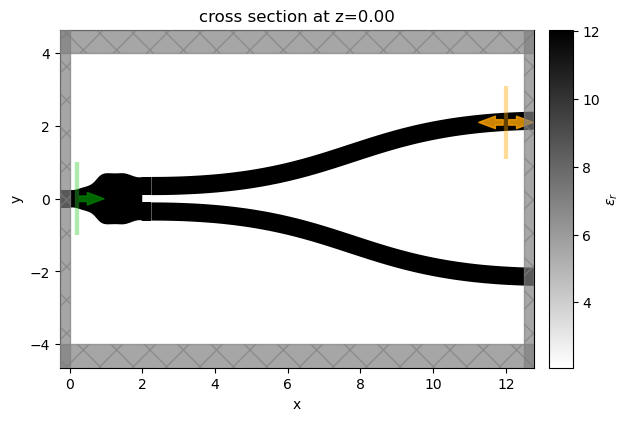

In [22]:
import matplotlib.pyplot as plt

lda0 = 1.55  # central wavelength
freq0 = td.C_0 / lda0  # central frequency
ldas = np.linspace(1.5, 1.6, 101)  # wavelength range
freqs = td.C_0 / ldas  # frequency range
fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the source frequency range

t_wg = 0.22
w1 = 0.5
# import material from pre-saved material data in Tidy3D's material library
si = td.material_library["cSi"]["Palik_Lossless"]
sio2 = td.material_library["SiO2"]["Palik_Lossless"]

si = td.Medium(permittivity=3.47**2)
sio2 = td.Medium(permittivity=1.44**2)

yj = td.Geometry.from_gds(
    gds_cell=coup_cell_loaded,
    axis=2,
    slab_bounds=(0, t_wg),
    gds_layer=1,
)

y_junction = td.Structure(
    geometry=yj, medium=si,
)

Lx = 12.5  # simulation domain size in x direction
Ly = 8  # simulation domain size in y direction
Lz = 10 * t_wg  # simulation domain size in z direction
sim_size = (Lx, Ly, Lz)

# add mode source as excitation
mode_spec = td.ModeSpec(num_modes=1, target_neff=3.5)
mode_source = td.ModeSource(
    center=(0.2, 0, t_wg / 2),
    size=(0, 4 * w1, 6 * t_wg),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

# add mode monitor to measure transmission at the output waveguide
mode_monitor = td.ModeMonitor(
    center=(12, 2.1, t_wg / 2),
    size=(0, 4 * w1, 6 * t_wg),
    freqs=freqs,
    mode_spec=mode_spec,
    name="mode",
)

# add field monitor to visualize field distribution at z=t/2
field_monitor = td.FieldMonitor(
    center=(0, 0, t_wg / 2), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

run_time = 5e-13

simY_3d = td.Simulation(
    center=(Lx / 2, 0, 0),
    size=sim_size,
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
    structures=[y_junction],
    sources=[mode_source],
    monitors=[mode_monitor, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=sio2,
)

simY_3d.plot_eps(z=0, freq=freq0)
plt.show()

Output()

16:41:28 CEST WARNING: Unable to fit with weighted RMS error under              
              'tolerance_rms' of 1e-05                                          

Output()

16:41:35 CEST WARNING: Unable to fit with weighted RMS error under              
              'tolerance_rms' of 1e-05                                          

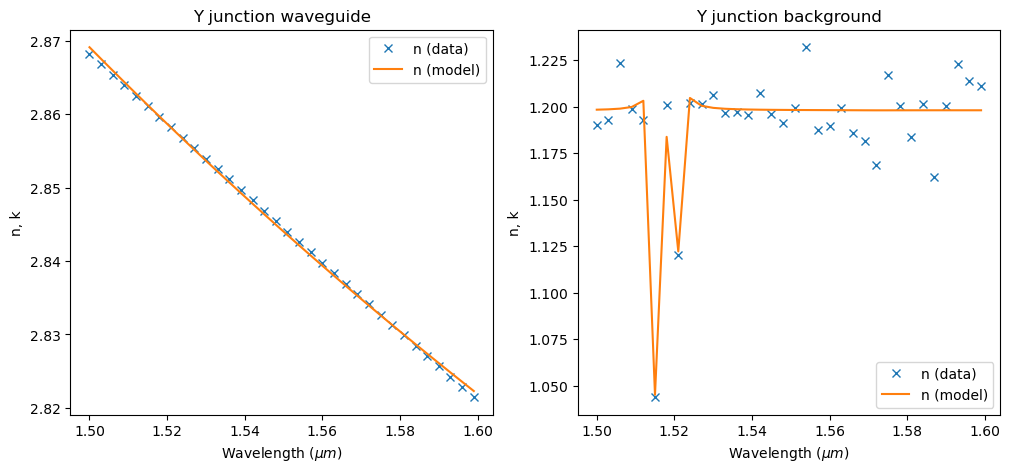

In [23]:
from tidy3d.plugins.dispersion import FastDispersionFitter

# again calculate the effective permittivity at every third wavelength
step = 3
reference_point = (1,0)
waveguide_eps, background_eps = [], []
for wl in ldas[::step]:
    waveguide_eps.append(var_eps_eff((1,0), reference_point, simY_3d, wavelength=wl))
    background_eps.append(var_eps_eff((6,0), reference_point, simY_3d, wavelength=wl))

# again fit and construct the materials from the calculated permittivities
waveguide_fitter = FastDispersionFitter(wvl_um=ldas[::step], n_data=np.sqrt(np.real(waveguide_eps)))
background_fitter = FastDispersionFitter(wvl_um=ldas[::step], n_data=np.sqrt(np.real(background_eps)))
waveguide_medium, rms_error = waveguide_fitter.fit()
background_medium, rms_error = background_fitter.fit()

fig, ax = plt.subplots(1, 2, figsize=(12,5))
waveguide_fitter.plot(waveguide_medium, ax=ax[0])
background_fitter.plot(background_medium, ax=ax[1])
ax[0].set_title("Y junction waveguide")
ax[1].set_title("Y junction background")
plt.show()

16:43:43 CEST WARNING: A bound of Simulation.structures[0] was detected as being
              within the simulation PML. We recommend extending structures to   
              infinity or completely outside of the simulation PML to avoid     
              unexpected effects when the structures are not translationally    
              invariant within the PML.                                         

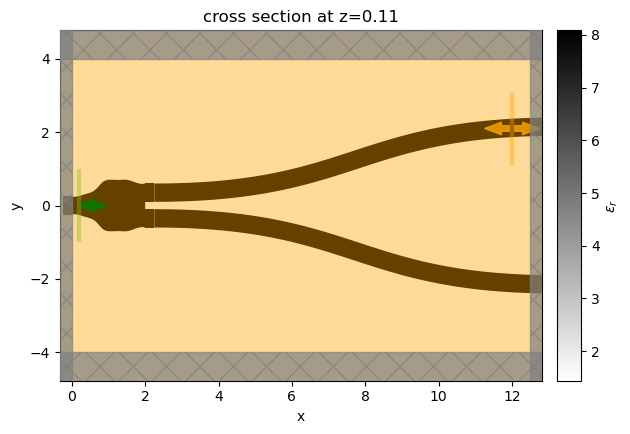

In [24]:
# again update the 3D simulation into a 2D simulation
new_structures = []
for structure in simY_3d.structures:
    new_structures.append(structure.updated_copy(medium=waveguide_medium))

new_size = list(simY_3d.size)
new_size[2] = 0

simY_2d = simY_3d.updated_copy(
    center=(Lx / 2, 0, t_wg/2),
    size=new_size,
    structures=new_structures,
    boundary_spec=simY_3d.boundary_spec.updated_copy(z=td.Boundary.periodic()),
    medium=background_medium,
)

simY_2d.plot_eps(z=t_wg/2, freq=freq0)
plt.show()

In [25]:
simY_2d_data = web.run(simY_2d, task_name="var eps Y 2D")

16:44:08 CEST Created task 'var eps Y 2D' with task_id                          
              'fdve-e96c9ce3-6c01-4ede-a9d3-e0dab2e23ad2' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=156735;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e96c9ce3-6c01-4ede-a9d3-e0dab2e23ad2\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=299648;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e96c9ce3-6c01-4ede-a9d3-e0dab2e23ad2\taskId]8;;\]8;id=156735;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e96c9ce3-6c01-4ede-a9d3-e0dab2e23ad2\=]8;;\]8;id=2200;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e96c9ce3-6c01-4ede-a9d3-e0dab2e23ad2\fdve]8;;\]8;id=156735;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e96c9ce3-6c01-4ede-a9d3-e0dab2e23ad2\-e96c9ce3-6c]8;;\
              ]8;id=156735;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e96c9ce3-6c01-4ede-a9d3-e0dab2e23ad2\01-4ede-a9d3-e0dab2e23ad2']8;;\.

Output()

16:44:14 CEST status = queued

Output()

16:44:18 CEST status = preprocess

16:44:21 CEST Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to   
              get the billed FlexCredit cost after a simulation run.

              starting up solver

16:44:22 CEST running solver

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

Output()

16:44:30 CEST status = postprocess

16:44:36 CEST status = success

              View simulation result at                                         
              ]8;id=841472;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e96c9ce3-6c01-4ede-a9d3-e0dab2e23ad2\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=809896;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e96c9ce3-6c01-4ede-a9d3-e0dab2e23ad2\taskId]8;;\]8;id=841472;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e96c9ce3-6c01-4ede-a9d3-e0dab2e23ad2\=]8;;\]8;id=943506;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e96c9ce3-6c01-4ede-a9d3-e0dab2e23ad2\fdve]8;;\]8;id=841472;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e96c9ce3-6c01-4ede-a9d3-e0dab2e23ad2\-e96c9ce3-6c]8;;\
              ]8;id=841472;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e96c9ce3-6c01-4ede-a9d3-e0dab2e23ad2\01-4ede-a9d3-e0dab2e23ad2']8;;\.

Output()

16:44:47 CEST loading simulation from simulation_data.hdf5

              WARNING: A bound of Simulation.structures[0] was detected as being
              within the simulation PML. We recommend extending structures to   
              infinity or completely outside of the simulation PML to avoid     
              unexpected effects when the structures are not translationally    
              invariant within the PML.                                         

              WARNING: Simulation final field decay value of 7.46e-05 is greater
              than the simulation shutoff threshold of 1e-05. Consider running  
              the simulation again with a larger 'run_time' duration for more   
              accurate results.                                                 

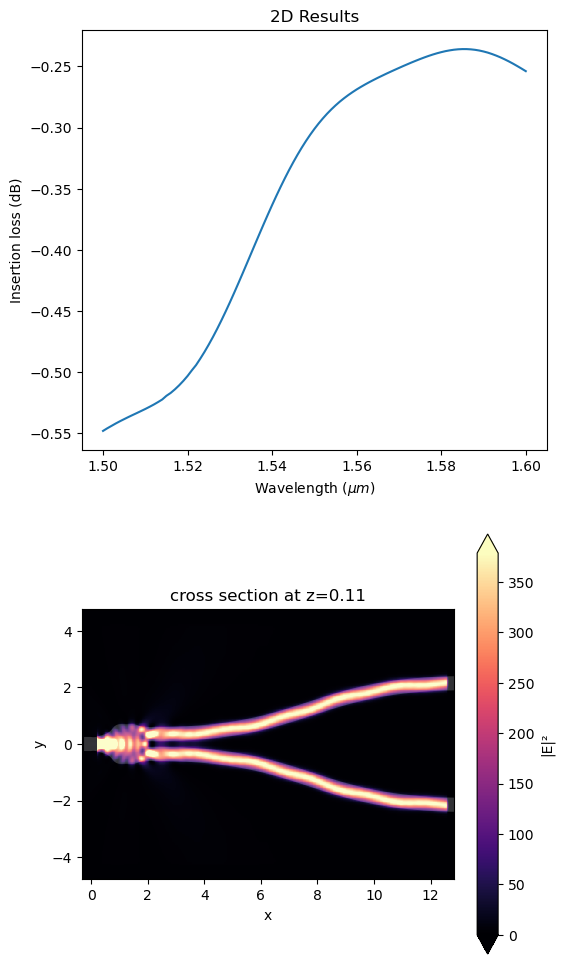

In [28]:
# calculate insertion loss from mode transmission from both simulations
amp2d = simY_2d_data["mode"].amps.sel(mode_index=0, direction="+")
loss2d = 10*np.log10(2*np.abs(amp2d)**2)

fig, ax = plt.subplots(2, 1, figsize=(6,12))

ax[0].set_title("2D Results")
ax[0].plot(ldas, loss2d)
ax[0].set_xlabel("Wavelength ($\mu m$)")
ax[0].set_ylabel("Insertion loss (dB)")
simY_2d_data.plot_field(field_monitor_name="field", field_name="E", val="abs^2", f=freq0, ax=ax[1])
plt.show()